In [ ]:
!apt-get install tesseract-ocr

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 46 not upgraded.
Need to get 4,850 kB of archives.
After this operation, 16.3 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1 [1,598 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr amd64 4.1.1-2build2 [262 kB]
Fetched 4,850 kB in 0s (12.0 MB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 122541 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-eng_1%3a

In [ ]:
!pip install pytesseract

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
import os

In [ ]:
def preprocessing(img, h1, h2, w1, w2):
    # get roi & resize
    y1, y2, x1, x2 = int(h1), int(h2), int(w1), int(w2)
    roi = img[y1:y2, x1:x2]
    scale = 300/roi.shape[0] # roi.shape[0] merupakan h image roi
    roi = cv2.resize(roi, (0,0), fx=scale, fy=scale)

    #convert to gray -> binary
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    __, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return thresh, roi, [x1, y1, x2, y2], scale

In [ ]:
# calculate contour & filter contour

def get_contours(thresh):
    contours, ___ = cv2.findContours(thresh, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    h, w, c = img.shape
    size = h*w
    contours = [cc for i, cc in enumerate(contours) if contour_char_OK(cc, size)]
    return contours

def contour_char_OK(cc, size=1000000):
    x, y, w, h = cv2.boundingRect(cc)
    area = cv2.contourArea(cc)

    if w < 3 or h < 5 or area < 80:
        return False

    validDimentson = w/h > 0.11 and w/h < 0.7 # filter rasio ukuran lebar / tinggi
    validAreaRatio = area/(w*h)  > 0.1 # filter rasio luasan (luas area putih / hitam)
    return validDimentson and validAreaRatio

def sort_contours(contours, method="left-to-right"):
    reverse = False
    i = 0
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True

    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    boundingBoxes = [cv2.boundingRect(cnt) for cnt in contours]

    cnts, boundingBoxes = zip(*sorted(zip(contours, boundingBoxes), key=lambda b:b[1][i], reverse=reverse))
    return cnts, boundingBoxes

In [ ]:
# draw label box pada original image
def drawPred(frame, label, left, top, right, bottom):
    cv2.rectangle(frame, (left, top), (right, bottom), (255, 0, 255), 2)

    labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    top = max(top, labelSize[1])
    cv2.rectangle(frame, (left, top - round(1.5*labelSize[1])),
                         (max(right, left + labelSize[0]), top + baseLine), (255, 0, 255), -1)

    cv2.putText(frame, label, (left, top), cv2.FONT_HERSHEY_SIMPLEX, 0.50, (255, 255, 255), 1)
    return frame

In [ ]:
# geometric tranformation & crop plat nomor
def order_points(pts):
    rect = np.zeros((4, 2), dtype = "float32")
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]

    rect[3] = pts[np.argmax(diff)]
    return np.array(rect)

def transform(img, pts, padding=0):
    pad = np.array([[-1, -1], [1, -1], [1, 1], [-1, 1]]) * padding
    rect = np.float32(order_points(pts) + pad)
    (tl, tr, br, bl) = rect

    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    dst = np.array([
        [0, 0],
        [maxWidth, 0],
        [maxWidth, maxHeight],
        [0, maxHeight]], dtype = "float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(img, M, (maxWidth, maxHeight))
    return np.int0(warped), rect

In [ ]:
# filter box yang tidak memiliki kedekatan jarak dan ukuran
def filter_boxes(boxes):
    boxes = np.array(boxes)
    boxes = nearest_box_position(boxes, label='x', n=3) #nearest box for closest `x`
    boxes = nearest_box_position(boxes, label='y', n=2) #nearest box for closest `y`
    boxes = nearest_box_size(boxes, label='w', n=2) #nearest box for closest `w`
    boxes = nearest_box_size(boxes, label='h', n=3) #nearest box for closest `h`
    return boxes

def nearest_box_position(boxes, label='x', n=2):
    pt = 0 if label == 'x' else 1
    mean = np.mean(boxes[:, 0, pt])
    std = np.std(boxes[:, 0, pt])
    boxes = np.array([box for box in boxes if abs(box[0, pt] - mean) < n*std])
    return boxes

def nearest_box_size(boxes, label='w', n=2):
    ptx = (1,0) if label == 'w' else (3,0)
    pt = 0 if label == 'w' else 1
    mean = np.mean(boxes[:, ptx[0], pt] - boxes[:, ptx[1], pt])
    std = np.std(boxes[:, ptx[0], pt] - boxes[:, ptx[1], pt])
    boxes = np.array([box for box in boxes if abs((box[ptx[0], pt] - box[ptx[1], pt]) - mean) < n*std])
    return boxes

In [ ]:
# menjadi 4 titik koordinat plat nomor
def get_plate_4_coord(contours):
    contours, rects = sort_contours(contours)
    boxes = []
    for cnt in contours:
        boxes.append(np.int0(cv2.boxPoints(cv2.minAreaRect(cnt))))

    # sort box tl, tr, br, bl
    boxes = [order_points(box) for box in boxes]

    # filter box
    boxes = filter_boxes(boxes)
    max_x_id = np.argmax(boxes[:,1,0])
    min_x_id = np.argmin(boxes[:,0,0])

    l, r = boxes[min_x_id], boxes[max_x_id]
    bl, tl = l[3], l[0]
    br, tr = r[2], r[1]

    return np.int0([tl, tr, br, bl])

In [ ]:
# menghitung lokasi box pada gambar original dari gambar ROI
def get_box_original(plate_rect, roi_rect, ratio):
    (x1, y1), (x2, y2) = plate_rect[0], plate_rect[2]
    x1_, y1_, x2_, y2_ = roi_rect
    l = int(x1/ratio) + x1_
    t = int(y1/ratio) + y1_
    r = int(x2/ratio) + x1_
    b = int(y2/ratio) + y1_
    return l, t, r, b

B 1567 SSR


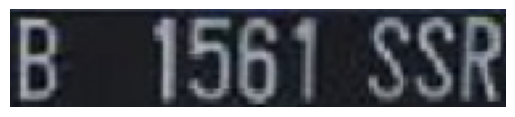

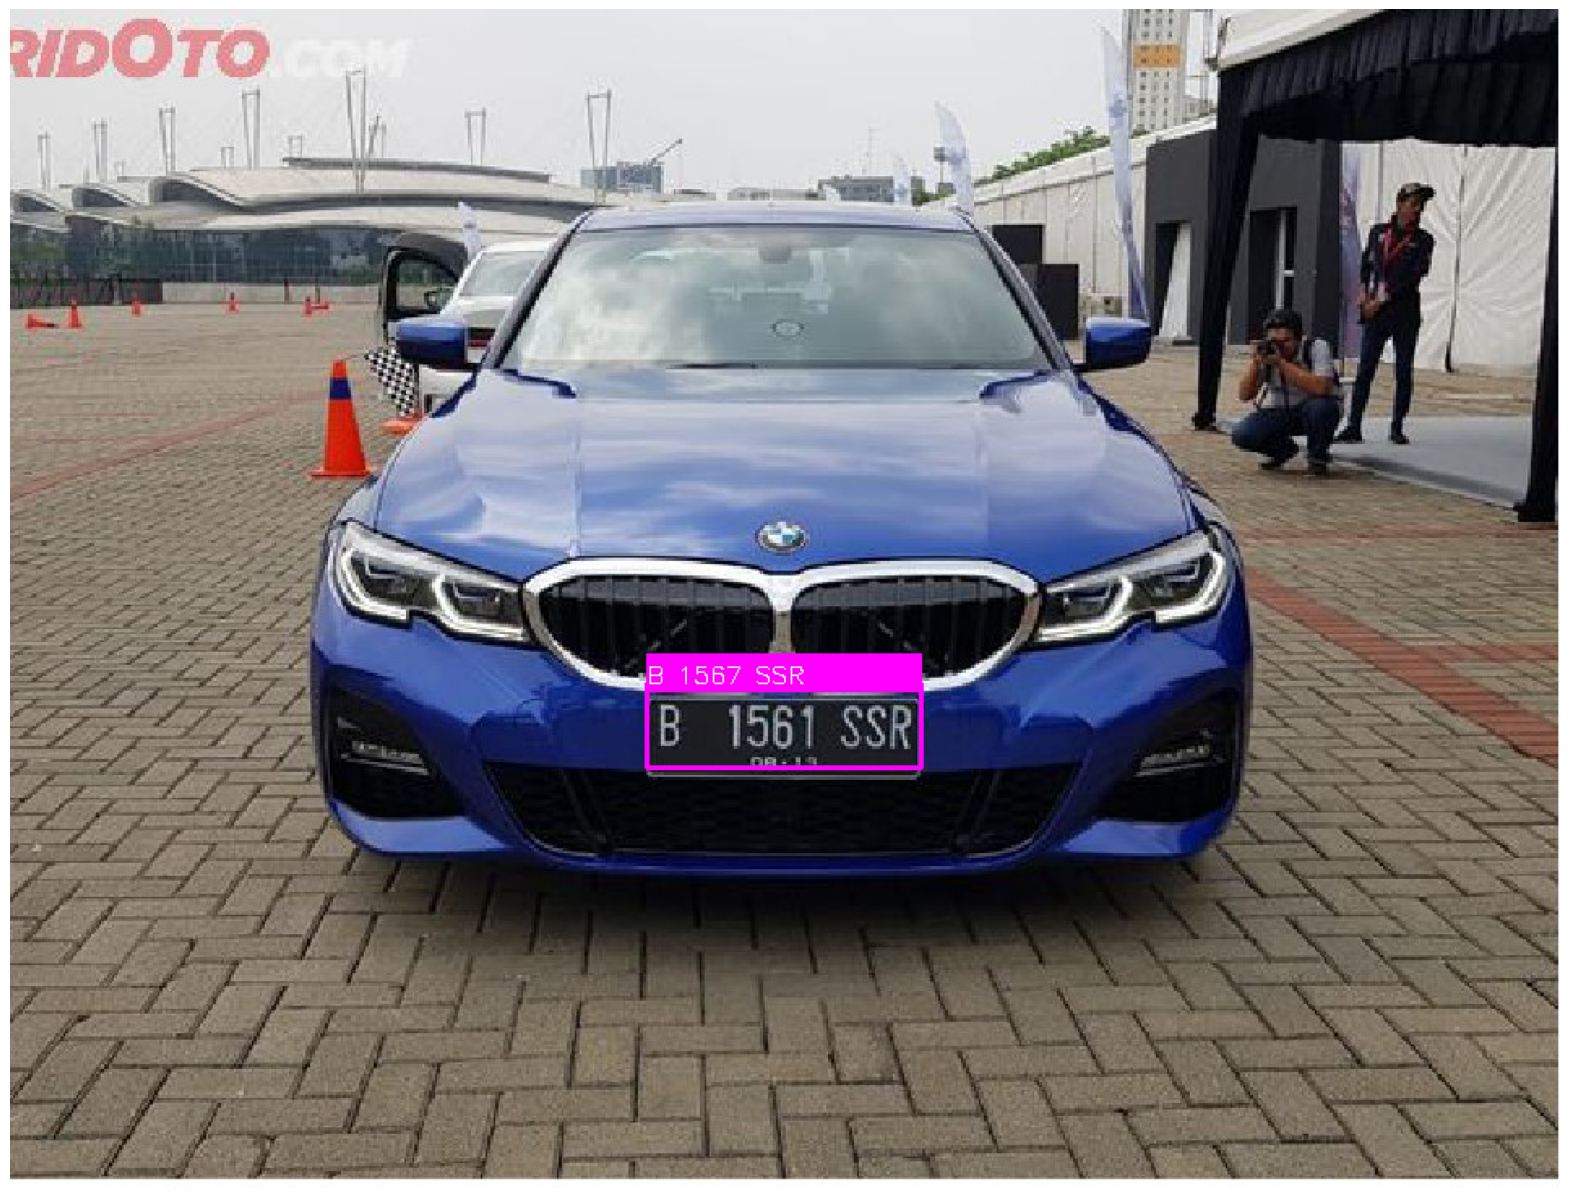

In [ ]:
img = cv2.imread("/content/data_test/WhatsApp Image 2023-06-14 at 19.44.29.jpeg")

h, w, c = img.shape
thresh, roi, roi_rect, ratio = preprocessing(img, h1=0.5*h, h2=0.85*h, w1=0.3*w, w2=0.7*w)
pytesseract.pytesseract.tesseract_cmd

# get contour
contours = get_contours(thresh)
pts = []

if len(contours) < 3:
    print("[STOP] tidak dapat mendeteksi plat nomor, contour terlalu sedikit..")
else:
    # get 4 point coordinate plate | pts = tl, tr, br, bl
    pts = get_plate_4_coord(contours)

    # geometric transform & crop plate number box
    plate_img, plate_rect = transform(roi, pts, padding=3)
    plate_img = np.uint8(plate_img)

    # recognize plate character
    configuration = "--oem 1 --psm 7"
    plate_text = pytesseract.image_to_string(plate_img, config=configuration)
    print(plate_text.strip())

    # draw label on image
    left, top, right, bottom = get_box_original(plate_rect, roi_rect, ratio)
    img = drawPred(img, plate_text.strip(), left - 5, top - 10, right + 5, bottom + 10)

    # display result
    plt.imshow(plate_img[:, :, ::-1])
    plt.axis('off')
    plt.show()

    plt.figure(figsize=(20, 20))
    plt.imshow(img[:, :, ::-1])
    plt.axis('off')
    plt.show()


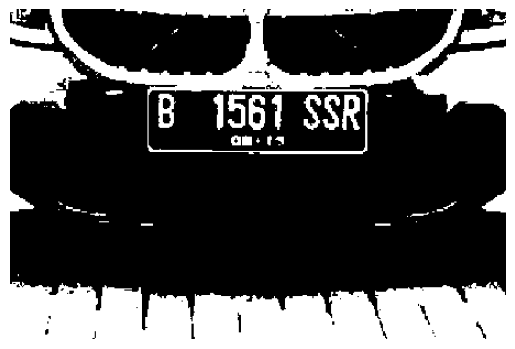

In [ ]:
plt.imshow(thresh, cmap="gray")
plt.axis('off')
plt.show()

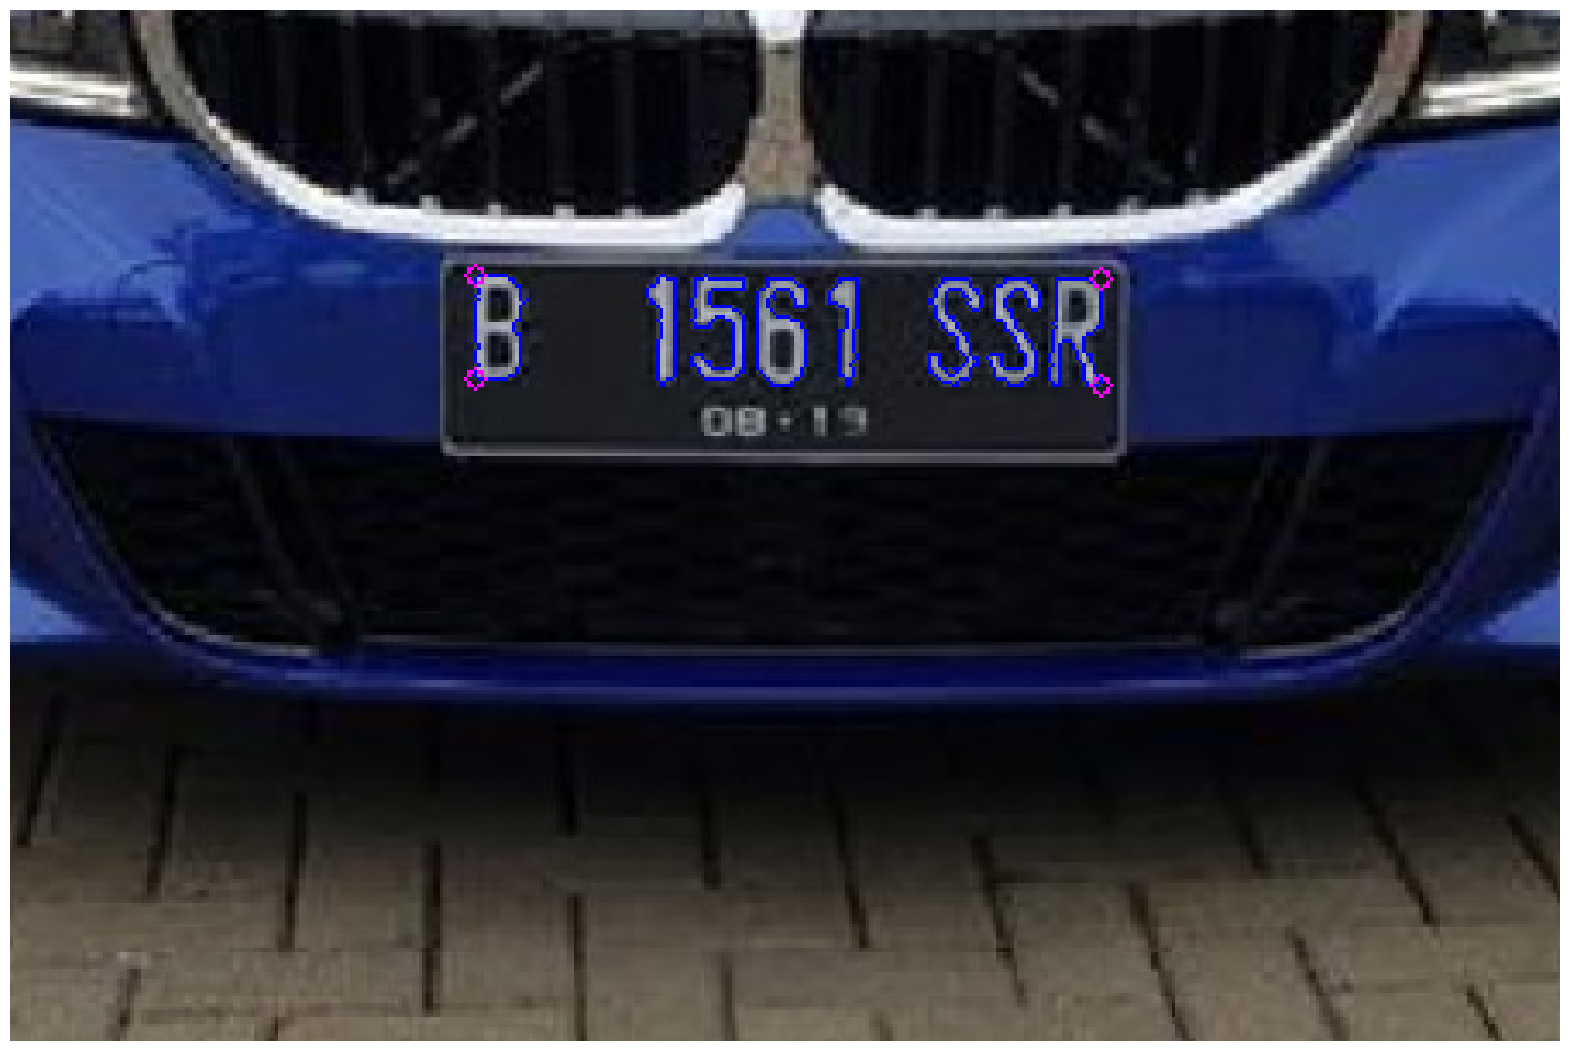

In [ ]:
for cnt in contours:
    cv2.drawContours(roi, [cnt], 0, (255, 0, 0), 1)

for pt in pts :
    cv2.circle(roi, (pt[0], pt[1]), 3, (255, 0, 255))

plt.figure(figsize=(20,20))
plt.imshow(roi[:,:,::-1])
plt.axis('off')
plt.show()

In [ ]:
dataset = "/content/data_test"
for filename in os.listdir(dataset):
    img = cv2.imread(os.path.join(dataset, filename))

    h, w, c = img.shape
    thresh, roi, roi_rect, ratio = preprocessing(img, h1=0.5*h, h2=0.85*h, w1=0.3*w, w2=0.7*w)

    # get contour
    contours = get_contours(thresh)

    if len(contours) < 3:
        print("[STOP] tidak dapat mendeteksi plat nomor, contour terlalu sedikit..")
    else:
        # get 4 point coordinate plate
        pts = get_plate_4_coord(contours)

        # geometric transform & crop plate number box
        plate_img, plate_rect = transform(roi, pts, padding=5)
        plate_img = np.uint8(plate_img)
        h, w, c = plate_img.shape

        # recognize plate character
        configuration = "--oem 1 --psm 7"
        plate_text = pytesseract.image_to_string(plate_img, config=configuration)

        # draw label on image
        left, top, right, bottom = get_box_original(plate_rect, roi_rect, ratio)
        img = drawPred(img, plate_text.strip(), left - 5, top - 10, right + 5, bottom + 10)

        # display result
        plt.imshow(plate_img[:, :, ::-1])
        plt.title("%s     (%d, %d)" % (plate_text.strip(), h, w))
        plt.axis('off')
        plt.show()

        plt.figure(figsize=(20, 20))
        plt.imshow(img[:, :, ::-1])
        plt.axis('off')
        plt.show()
